In [ ]:
%pip install -q ../introdl

In [1]:
# configuration
data_dir = '../../data' # directory to save data - change as needed

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style='whitegrid')
plt.rcParams['figure.figsize'] = [8, 6]  # Set the default figure size (width, height) in inches

from sklearn.metrics import accuracy_score

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split

import torchvision.transforms as transforms
from torchvision.datasets import MNIST

from introdl.utils import get_device, load_results, summarizer
from introdl.idlmam import train_network
from introdl.visul import plot_training_metrics

# The Power of Residual Connections

In this demo, we'll illustrate the power of residual connections by comparing the training of two deep neural networks:

1. **A Plain Deep Network** without residual connections.
2. **A Residual Network (ResNet)** with residual connections.

We'll use PyTorch to build and train both models on a simple dataset.

### **Objective**

- Show how residual connections improve the training of deep neural networks.
- Compare the performance (training loss and accuracy) of the plain network and the residual network.

### **Dataset**

For simplicity and speed, we'll use the **MNIST** dataset of handwritten digits.

### Data Preparation



In [2]:

# Transformations for the data
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))  # Mean and std for MNIST
])

# Load training and test datasets
train_dataset = MNIST(root=data_dir, train=True, download=True, transform=transform)
test_dataset  = MNIST(root=data_dir, train=False, download=True, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_dataset, batch_size=1000, shuffle=False)




### **Step 3: Define the Models**

#### **3.1 Plain Deep Network**

We'll define a plain deep network with multiple layers but without residual connections.

The `PlainNetwork` architecture is a fully connected (feedforward) neural network without residual connections, designed for simplicity and to illustrate the difficulty of training deep networks as they grow in depth. Here's a detailed description of its architecture and components:

### **Detailed Layer Structure:**

Let's break down the architecture assuming 20 hidden layers and a hidden size of 64 units:

1. **Input Layer:**
   - **Input size:** \(784\) (28x28 flattened image).
   - **First Linear Layer:** Transforms the 784-dimensional input into a 64-dimensional vector.
   
2. **Hidden Layers:**
   - There are 20 fully connected (dense) hidden layers.
   - Each hidden layer applies a **linear transformation** followed by a **ReLU activation**.
   - Each hidden layer maps from 64 units to 64 units.
   
3. **Output Layer:**
   - After passing through all the hidden layers, the network connects to the output layer.
   - **Output size:** 10 units (one for each class in a classification problem like MNIST).

### **Potential Issues with PlainNetwork:**
- **Vanishing Gradient Problem:** In deep networks like `PlainNetwork`, gradients can become very small as they propagate back through the layers, making it hard for the network to learn effectively during training. This is a key limitation of deep networks without residual connections.
- **Slow Convergence:** Without shortcut (residual) connections, it might take a long time to converge or it might fail to converge altogether, especially for networks with many layers.

### **Why It’s Important:**
The `PlainNetwork` demonstrates the challenges of training deep networks without any form of residual connections or other advanced techniques like batch normalization. When you increase the depth of the network (e.g., with 20 or more layers), the model can become difficult to train due to problems like vanishing gradients and slow convergence. This is why architectures like **ResNet** (which includes residual connections) were introduced to solve these issues.


In [6]:
class PlainNetwork(nn.Module):
    def __init__(self):
        super(PlainNetwork, self).__init__()
        layers = []
        input_dim = 28 * 28  # MNIST images are 28x28
        hidden_dim = 64
        num_layers = 20  # Deep network

        # Create a sequence of linear layers with ReLU activation
        for _ in range(num_layers):
            layers.append(nn.Linear(input_dim, hidden_dim))
            layers.append(nn.ReLU(inplace=True))
            input_dim = hidden_dim

        layers.append(nn.Linear(hidden_dim, 10))  # Output layer for 10 classes
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        return self.net(x)


## Batch Normalization Network

The **BNNetwork** is a modified version of the **PlainNetwork**, where **batch normalization** layers are added after each fully connected layer but before the activation function. The primary purpose of batch normalization is to normalize the output of each layer before passing it to the next layer, helping stabilize and accelerate training.

### **Detailed Layer Structure:**

1. **Input Layer:**
   - Input size: 784 (flattened image).
   - First linear layer transforms the input into a 64-dimensional vector.
   
2. **Hidden Layers (with Batch Normalization):**
   - 20 fully connected layers, each consisting of:
     - Linear transformation from 64 units to 64 units.
     - Batch normalization.
     - ReLU activation function.
   

### **Benefits of Batch Normalization:**

1. **Faster Convergence:**
   - By normalizing the inputs to each layer, batch normalization reduces the internal covariate shift, leading to faster and more stable convergence during training.
   
2. **Regularization Effect:**
   - Batch normalization introduces a slight regularization effect by adding noise to the network through mini-batch statistics. This can reduce the reliance on other regularization techniques like dropout.

3. **Improved Gradient Flow:**
   - Batch normalization helps keep the gradients more stable, allowing for deeper networks to be trained without suffering from the vanishing/exploding gradient problem.

### **Key Points:**

- **Batch Normalization:** The main modification in `BNNetwork` compared to `PlainNetwork` is the introduction of **batch normalization** after each linear layer. This improves training stability and speed.
- **Linear Layers + BatchNorm + ReLU:** Each hidden layer in the network follows the pattern of a linear transformation, followed by batch normalization and then a ReLU activation.
- **Fully Connected Layers:** Like the `PlainNetwork`, the `BNNetwork` consists of fully connected layers, but batch normalization helps mitigate the training challenges often encountered with deep networks.

### **Why Batch Normalization is Important:**

- **More Stable Learning:** In deep networks, activations in earlier layers can change significantly as weights update, leading to unstable learning. Batch normalization addresses this by stabilizing the activations.
- **Easier to Tune Learning Rates:** Networks with batch normalization often allow for higher learning rates, which can lead to faster training times.
- **Improved Performance on Test Data:** By reducing internal covariate shift and providing regularization, batch normalization can lead to better generalization on unseen data.

In [9]:
class BNNetwork(nn.Module):
    def __init__(self, input_size=784, hidden_size=64, output_size=10, num_layers=20):
        super(BNNetwork, self).__init__()
        layers = []

        # Input layer to the first hidden layer
        layers.append(nn.Linear(input_size, hidden_size))
        layers.append(nn.BatchNorm1d(hidden_size))  # Add BatchNorm after the first linear layer
        layers.append(nn.ReLU())
        
        # Hidden layers with BatchNorm
        for _ in range(num_layers - 1):
            layers.append(nn.Linear(hidden_size, hidden_size))
            layers.append(nn.BatchNorm1d(hidden_size))  # BatchNorm for hidden layers
            layers.append(nn.ReLU())

        # Output layer
        layers.append(nn.Linear(hidden_size, output_size))

        # Store layers in a Sequential block
        self.net = nn.Sequential(*layers)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        return self.net(x)



#### **3.2 Residual Network**

We'll define a residual network with the same depth but include residual connections.

The `ResidualNetwork` architecture is designed to address some of the training challenges associated with deep networks, such as the **vanishing gradient problem**, by incorporating **residual connections**. These residual connections allow the network to "skip" one or more layers by adding the input of a layer directly to its output, which helps preserve the gradient during backpropagation and facilitates the training of much deeper networks.

### **Detailed Layer Structure:**

1. **Input Layer:**
   - **Input size:** \(784\) (28x28 flattened image).
   - The input is transformed into a 64-dimensional vector by the first linear layer.
   
2. **Residual Blocks (with Skip Connections):**
   - The `ResidualNetwork` consists of **20 residual blocks**.
   - Each block applies a **linear transformation** followed by **ReLU activation** and then adds the input to the output (the residual or skip connection).
   - Each block maps from 64 units to 64 units.
   
3. **Output Layer:**
   - After passing through all the residual blocks, the network connects to the output layer.
   - **Output size:** 10 units (one for each class in a classification problem like MNIST).

### **Residual Block:**

Each residual block can be described by the following operation:
$$\text{out} = \text{ReLU}(\text{Linear}(x)) + x$$
where $x$ is the input to the block and the output is the sum of the transformed input and the input itself.

### **Key Points:**
- **Residual Connections:** The defining feature of the `ResidualNetwork` is the skip connection in each residual block, where the input to a block is added to the output of the block. This allows the network to bypass (skip) one or more layers, helping to preserve the flow of gradients during training and enabling the training of much deeper networks.
- **Depth:** The depth of the network (number of residual blocks) is customizable via the `num_blocks` parameter.
- **Fully Connected Layers:** Every residual block contains a fully connected (dense) layer, followed by a ReLU activation and a residual (skip) connection.
- **Improved Training:** The residual connections make it easier to train deeper networks by solving the vanishing gradient problem, which occurs when gradients become too small to propagate back through the layers during backpropagation.

### **Why It’s Important:**
The `ResidualNetwork` demonstrates the power of **residual connections** (also known as **skip connections**) in addressing the challenges of training deep networks. With residual connections, even very deep networks can be trained effectively, whereas without them, deep networks like the `PlainNetwork` can suffer from slow convergence or fail to learn effectively.



In [5]:
class ResidualBlock(nn.Module):
    def __init__(self, dim):
        super(ResidualBlock, self).__init__()
        self.linear = nn.Linear(dim, dim)
        self.relu = nn.ReLU(inplace=False)

    def forward(self, x):
        residual = x
        out = self.linear(x)
        out = self.relu(out)
        out = out + residual  # Residual connection
        return out

class ResidualNetwork(nn.Module):
    def __init__(self):
        super(ResidualNetwork, self).__init__()
        input_dim = 28 * 28
        hidden_dim = 64
        num_blocks = 20  # Deep network

        self.input_layer = nn.Linear(input_dim, hidden_dim)
        self.blocks = nn.ModuleList([ResidualBlock(hidden_dim) for _ in range(num_blocks)])
        self.output_layer = nn.Linear(hidden_dim, 10)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        out = self.input_layer(x)
        for block in self.blocks:
            out = block(out)
        out = self.output_layer(out)
        return out

## Batch Norm and Residuals

The **BNResidualNetwork** is a combination of two key techniques: **batch normalization** and **residual connections**. This architecture leverages the benefits of both techniques to create a deep neural network that is easier to train and generalizes well.

- **Residual connections** help the model avoid the vanishing gradient problem, allowing it to train deeper networks effectively by enabling skip connections.
- **Batch normalization** stabilizes and accelerates training by normalizing layer inputs, making the network less sensitive to initialization and learning rates.

### **Detailed Layer Structure:**

1. **Input Layer:**
   - Input size: 784 (for flattened 28x28 images).
   - First linear layer transforms the input into a hidden size of 64 units.
   
2. **Residual Blocks (with Batch Normalization):**
   - The architecture consists of multiple **residual blocks** (e.g., 20 blocks), where each block includes:
     - A **linear transformation**.
     - A **batch normalization** layer.
     - A **ReLU activation**.
     - A **skip connection** that adds the input to the output of the block.
   
3. **Output Layer:**
   - After the last residual block, the output layer maps the hidden size (64 units) to the output size (10 classes for MNIST).

### **Advantages of Combining Batch Normalization and Residuals:**

1. **Batch Normalization:**
   - Helps stabilize the learning process by normalizing the input to each layer, reducing the internal covariate shift.
   - Allows for faster convergence and higher learning rates.
   - Acts as a regularizer, reducing the need for other regularization techniques like dropout.

2. **Residual Connections:**
   - Allow gradients to flow more easily through the network, mitigating the vanishing gradient problem in deep networks.
   - Facilitate the training of much deeper networks by providing an identity mapping for the network to fall back on if deeper layers are not needed to model the data.

3. **Combined Benefits:**
   - The combination of **batch normalization** and **residual connections** allows for faster training of deep networks and better performance.
   - Batch normalization ensures that the layers are receiving well-scaled inputs, while residual connections prevent degradation of the model’s performance as depth increases.

### **Key Points:**

- **Residual Connections:** The skip connections in each residual block allow gradients to flow through the network more easily, enabling the training of deeper networks.
- **Batch Normalization:** By applying batch normalization before ReLU activations, the network can stabilize learning, leading to faster convergence and improved generalization.
- **Deep Network:** The network can be made arbitrarily deep (via the `num_blocks` parameter), but the combination of batch normalization and residual connections ensures it remains trainable and efficient.

### **Why This Architecture is Important:**

The **BNResidualNetwork** leverages two powerful techniques—batch normalization and residual connections—to address the challenges of training deep neural networks:
- **Training Stability:** Batch normalization improves stability, while residual connections ensure that the network does not suffer from vanishing gradients.
- **Scalability:** This architecture can be scaled to very deep networks without suffering from performance degradation, making it suitable for complex tasks that require deep learning models.



In [12]:
import torch
import torch.nn as nn

class BNResidualBlock(nn.Module):
    def __init__(self, hidden_size):
        super(BNResidualBlock, self).__init__()
        self.linear = nn.Linear(hidden_size, hidden_size)
        self.batchnorm = nn.BatchNorm1d(hidden_size)  # Add BatchNorm
        self.relu = nn.ReLU()
    
    def forward(self, x):
        residual = x  # Save the input for the skip connection
        out = self.linear(x)  # Linear transformation
        out = self.batchnorm(out)  # Apply BatchNorm
        out = self.relu(out)  # ReLU activation
        out = out + residual  # Add the input (residual connection)
        return out

class BNResidualNetwork(nn.Module):
    def __init__(self, input_size=784, hidden_size=64, output_size=10, num_blocks=20):
        super(BNResidualNetwork, self).__init__()
        
        # Input layer: Fully connected layer from input_size to hidden_size
        self.input_layer = nn.Linear(input_size, hidden_size)
        
        # Residual blocks with batch normalization and skip connections
        self.blocks = nn.ModuleList([BNResidualBlock(hidden_size) for _ in range(num_blocks)])
        
        # Output layer: Fully connected layer from hidden_size to output_size
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = x.view(x.size(0), -1)  # Flatten the input
        out = self.input_layer(x)  # Input layer transformation
        
        # Pass through each residual block
        for block in self.blocks:
            out = block(out)
        
        # Output layer transformation
        out = self.output_layer(out)
        return out


In [8]:
model = PlainNetwork()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters())

device = get_device()
print(device)

ckpt_file = 'models/Plain_MNIST.pt'
epochs = 10

score_funcs = {'ACC':accuracy_score}

results = train_network(model,
                loss_func,
                train_loader,
                device=device,
                test_loader=test_loader,
                epochs = epochs,
                optimizer = optimizer,
                score_funcs = {'ACC':accuracy_score},
                checkpoint_file = ckpt_file)

mps


Epoch: 100%|██████████| 10/10 [03:18<00:00, 19.85s/it]


In [10]:
model = BNNetwork()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters())

device = get_device()
print(device)

ckpt_file = 'models/BN_MNIST.pt'
epochs = 10

score_funcs = {'ACC':accuracy_score}

results = train_network(model,
                loss_func,
                train_loader,
                device=device,
                test_loader=test_loader,
                epochs = epochs,
                optimizer = optimizer,
                score_funcs = {'ACC':accuracy_score},
                checkpoint_file = ckpt_file)

mps


Epoch: 100%|██████████| 10/10 [05:26<00:00, 32.63s/it]


In [6]:
model = ResidualNetwork()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters())

device = get_device()
print(device)

ckpt_file = 'models/Residual_MNIST.pt'
epochs = 10

score_funcs = {'ACC':accuracy_score}

results = train_network(model,
                loss_func,
                train_loader,
                device=device,
                test_loader=test_loader,
                epochs = epochs,
                optimizer = optimizer,
                score_funcs = {'ACC':accuracy_score},
                checkpoint_file = ckpt_file)

mps


Epoch: 100%|██████████| 10/10 [03:39<00:00, 21.97s/it]


In [13]:
model = BNResidualNetwork()
loss_func = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters())

device = get_device()
print(device)

ckpt_file = 'models/BNResidual_MNIST.pt'
epochs = 10

score_funcs = {'ACC':accuracy_score}

results = train_network(model,
                loss_func,
                train_loader,
                device=device,
                test_loader=test_loader,
                epochs = epochs,
                optimizer = optimizer,
                score_funcs = {'ACC':accuracy_score},
                checkpoint_file = ckpt_file)

mps


Epoch: 100%|██████████| 10/10 [05:44<00:00, 34.42s/it]


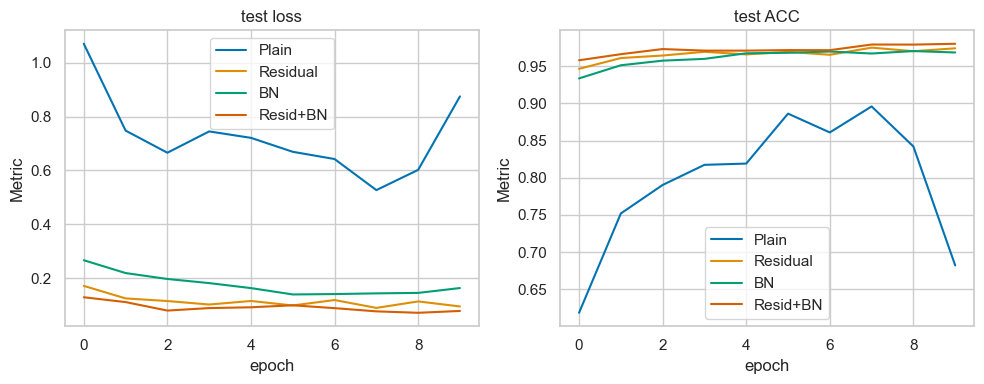

In [15]:
results_plain = load_results('models/Plain_MNIST.pt')
results_resid = load_results('models/Residual_MNIST.pt')
results_bn = load_results('models/BN_MNIST.pt')
results_bn_resid = load_results('models/BNResidual_MNIST.pt')

plot_training_metrics(
    [results_plain,results_resid, results_bn, results_bn_resid], 
    [['test loss'], ['test ACC']],
    #[['train loss', 'test loss'], 
    # ['train ACC', 'test ACC']], 
     df_labels=['Plain', 'Residual', 'BN', 'Resid+BN'])



### **Expected Results**

- **Plain Network:** Due to the depth and lack of residual connections, the plain network may struggle to converge. The training loss might decrease very slowly, and the accuracy might remain low.
- **Residual Network:** The residual connections help the network train more effectively. We expect to see a faster decrease in training loss and higher accuracy compared to the plain network.

### **Explanation**

- **Vanishing Gradient Problem:** In deep networks, gradients can become extremely small during backpropagation, making it difficult to update the weights effectively. This leads to slow or stalled training.
- **Residual Connections:** By adding the input of a layer to its output (`out += residual`), we provide a direct path for the gradient to flow backward through the network. This helps maintain gradient magnitude and allows for more effective training of deep networks.

### **Conclusion**

This demo illustrates how residual connections enable the training of deep neural networks by mitigating the vanishing gradient problem. The residual network outperforms the plain network in both training loss reduction and accuracy improvement.

---

**Note:** For a more comprehensive experiment, you can increase the number of epochs or adjust hyperparameters. Additionally, consider using a GPU for faster training if available.